**Lab 2 – Framing the problem and constructing the dataset**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/02_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/02_Dataset.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [64]:
!pip install git+https://github.com/phonchi/pigeonXT.git 
!pip install cleanlab -qq
!pip install modAL -qq
!pip install snorkel -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/phonchi/pigeonXT.git to /tmp/pip-req-build-uiyaa4xt
  Running command git clone --filter=blob:none --quiet https://github.com/phonchi/pigeonXT.git /tmp/pip-req-build-uiyaa4xt
  Resolved https://github.com/phonchi/pigeonXT.git to commit 6564faf5101f33724a63a36231f74a3c4fa2ff3c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.24.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.1

In [68]:
# Built-in function
import glob
import os
import subprocess
import re
import random

# Scientific computing
import numpy as np
import pandas as pd
from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

# Modeling
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Manual labeling
import pigeonXT as pixt

# Concensus algorithm
from cleanlab.multiannotator import get_label_quality_multiannotator, get_majority_vote_label
from cleanlab.benchmarking.noise_generation import generate_noise_matrix_from_trace
from cleanlab.benchmarking.noise_generation import generate_noisy_labels

# Active learning
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

# Weak supervision
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
from snorkel.preprocess.nlp import SpacyPreprocessor
from snorkel.labeling.lf.nlp import nlp_labeling_function

# Data augmentation
from skimage import io
import albumentations as A

In [3]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

## Scraping data using BeautifulSoup

Sometimes we have to build our dataset using crawler. See
1. https://github.com/marvelje/weather_forecasting (Constructing weather dataste)
2. https://www.kaggle.com/code/pandula/a-simple-tutorial-on-beautifulsoup/notebook (Constructing IMDB dataset)
3. https://github.com/sharmasapna/Web-scraping-for-images
(Constructing image dataset)


## Manual Labeling with pigeonXT

In many data science projects, the first step at which the data science team gets involved is in labeling the image data. Even if the labeling will be automated, the first few images in a proof of concept are almost always hand-labeled. The form and organization will differ based on the problem type (image classification or object detection) and whether an image can have multiple labels or only one. To hand-label images, a rater views the image, determines the label(s), and records the label(s). There are two typical approaches to doing this recording: using a **folder structure** and a **metadata table.**

In a folder organization, raters simply move images to different folders depending on what their label is. All flowers that are daisies are stored in a folder named *daisy*, for example. Raters can do this quickly because most operating systems provide previews of images and handy ways to select groups of images and move them into folders.

The problem with the folder approach is that it leads to duplication if an image can have multiple labels—for example, if an image contains both *roses* and *daisies*. The alternative, and recommended, approach is to record the label(s) in a metadata table (such as in a spreadsheet or a CSV file) that has at least two columns - one column is the filename of the image file, and the other is the list of labels that are valid for the image.

A labeling tool should have a facility to display the image, and enable the rater to quickly select valid categories and save the rating to a database. We will use `pigeonXT` which is a wrapper of Jupyter widget next.



### Image classification

In [4]:
%%bash
mkdir flower_images
for filename in 100080576_f52e8ee070_n.jpg 10140303196_b88d3d6cec.jpg 10172379554_b296050f82_n.jpg; do
  gsutil cp gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/$filename flower_images
done

Copying gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/100080576_f52e8ee070_n.jpg...
/ [1 files][ 26.2 KiB/ 26.2 KiB]                                                
Operation completed over 1 objects/26.2 KiB.                                     
Copying gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/10140303196_b88d3d6cec.jpg...
/ [1 files][114.5 KiB/114.5 KiB]                                                
Operation completed over 1 objects/114.5 KiB.                                    
Copying gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/10172379554_b296050f82_n.jpg...
/ [1 files][ 35.6 KiB/ 35.6 KiB]                                                
Operation completed over 1 objects/35.6 KiB.                                     


In [5]:
filenames = glob.glob('flower_images/*.jpg')
print(filenames)

['flower_images/10140303196_b88d3d6cec.jpg', 'flower_images/100080576_f52e8ee070_n.jpg', 'flower_images/10172379554_b296050f82_n.jpg']


In [8]:
annotations = pixt.annotate(
      filenames,
      options=['daisy', 'tulip', 'rose'],
      display_fn=lambda filename: display.display(display.Image(filename))
)

HTML(value='0 of 3 Examples annotated, Current Position: 0 ')

Output()

Annotation done.


In [9]:
annotations

,example,changed,label
0,flower_images/10140303196_b88d3d6cec.jpg,False,
1,flower_images/100080576_f52e8ee070_n.jpg,False,
2,flower_images/10172379554_b296050f82_n.jpg,True,daisy


### Binary or multi-class text classification

In [10]:
annotations = pixt.annotate(
        ['I love this movie', 'I was really disappointed by the book'],
        options=['positive', 'negative', 'inbetween']
    )

HTML(value='0 of 2 Examples annotated, Current Position: 0 ')

Output()

Annotation done.


In [11]:
annotations

,example,changed,label
0,I love this movie,True,positive
1,I was really disappointed by the book,True,negative


The output can be save to a CSV or JSON file.

In [12]:
annotations.to_csv("text_class_dataset.csv")

### Multi-label text classification

In [13]:
df = pd.DataFrame([
        {'example': 'Star wars'},    
        {'example': 'The Positively True Adventures of the Alleged Texas Cheerleader-Murdering Mom'},
        {'example': 'Eternal Sunshine of the Spotless Mind'},
        {'example': 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb'},    
        {'example': 'Killer klowns from outer space'},    
    ])

labels = ['Adventure', 'Romance', 'Fantasy', 'Science fiction', 'Horror', 'Thriller']
    
annotations = pixt.annotate(
        df, 
        options=labels, 
        task_type='multilabel-classification',
        buttons_in_a_row=3,
        reset_buttons_after_click=True,
        include_next=True,
        include_back=True,
    )  

HTML(value='0 of 5 Examples annotated, Current Position: 0 ')

Output()

Annotation done.


In [14]:
annotations

,example,changed,Adventure,Romance,Fantasy,Science fiction,Horror,Thriller
0,Star wars,True,True,False,False,True,False,False
1,The Positively True Adventures of the Alleged ...,True,True,False,False,False,False,False
2,Eternal Sunshine of the Spotless Mind,False,False,False,False,False,False,False
3,Dr. Strangelove or: How I Learned to Stop Worr...,False,False,False,False,False,False,False
4,Killer klowns from outer space,True,False,False,False,True,True,True


In [15]:
annotations.to_csv("text_multilabel_dataset.csv")

Anything that can be displayed on Jupyter (text, images, audio, graphs, etc.)can be displayed by pigeonXT by providing the appropriate `display_fn` argument.

Additionally, custom hooks can be attached to each row update (`example_process_fn`), or when the annotating task is complete(`final_process_fn`). See https://github.com/dennisbakhuis/pigeonXT for more details.

## Improve Consensus Labels for Multiannotator Data with Cleanlab

This example contains classification data that has been labeled by multiple annotators (where each example has been labeled by at least one annotator, but not every annotator has labeled every example)

For this part, we will generate a toy dataset that has 50 annotators and 300 examples. There are three possible classes, 0, 1 and 2.

Each annotator annotates approximately 10% of the examples. We also synthetically made the last 5 annotators in our toy dataset have much noisier labels than the rest of the annotators. To generate our multiannotator data, we define a `make_data()` method 

In [69]:
SEED = 111 # set to None for non-reproducible randomness
np.random.seed(seed=SEED)

def make_data(
    means=[[3, 2], [7, 7], [0, 8]],
    covs=[[[5, -1.5], [-1.5, 1]], [[1, 0.5], [0.5, 4]], [[5, 1], [1, 5]]],
    sizes=[150, 75, 75],
    num_annotators=50,
):

    m = len(means)  # number of classes
    n = sum(sizes)
    local_data = []
    labels = []

    for idx in range(m):
        local_data.append(
            np.random.multivariate_normal(mean=means[idx], cov=covs[idx], size=sizes[idx])
        )
        labels.append(np.array([idx for i in range(sizes[idx])]))
    X_train = np.vstack(local_data)
    true_labels_train = np.hstack(labels)

    # Compute p(true_label=k)
    py = np.bincount(true_labels_train) / float(len(true_labels_train))

    noise_matrix_better = generate_noise_matrix_from_trace(
        m,
        trace=0.8 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    noise_matrix_worse = generate_noise_matrix_from_trace(
        m,
        trace=0.35 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    # Generate our noisy labels using the noise_matrix for specified number of annotators.
    s = pd.DataFrame(
        np.vstack(
            [
                generate_noisy_labels(true_labels_train, noise_matrix_better)
                if i < num_annotators - 5
                else generate_noisy_labels(true_labels_train, noise_matrix_worse)
                for i in range(num_annotators)
            ]
        ).transpose()
    )

    # Each annotator only labels approximately 10% of the dataset
    # (unlabeled points represented with NaN)
    s = s.apply(lambda x: x.mask(np.random.random(n) < 0.9)).astype("Int64")
    s.dropna(axis=1, how="all", inplace=True)
    s.columns = ["A" + str(i).zfill(4) for i in range(1, num_annotators+1)]

    row_NA_check = pd.notna(s).any(axis=1)

    return {
        "X_train": X_train[row_NA_check],
        "true_labels_train": true_labels_train[row_NA_check],
        "multiannotator_labels": s[row_NA_check].reset_index(drop=True),
    }

Let’s view the first few rows of the data. Here are the labels selected by each annotator for the first few examples:

In [70]:
data_dict = make_data()

X = data_dict["X_train"]
multiannotator_labels = data_dict["multiannotator_labels"]
true_labels = data_dict["true_labels_train"] # used for comparing the accuracy of consensus labels

In [71]:
multiannotator_labels.head()

,A0001,A0002,A0003,A0004,A0005,A0006,A0007,A0008,A0009,A0010,...,A0041,A0042,A0043,A0044,A0045,A0046,A0047,A0048,A0049,A0050
0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>
3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>,...,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,2,<NA>,<NA>,0,<NA>,<NA>,<NA>


`multiannotator_labels` contains the class labels that each annotator chose for each example, with examples that a particular annotator did not label represented using `np.nan`. `X` contains the features for each example.

### Get majority vote labels and compute out-of-sample predicted probabilites

Before training a machine learning model, we must first obtain the consensus labels from the annotators that labeled the data. The simplest way to obtain an initial set of consensus labels is to select it using majority vote.

In [72]:
majority_vote_label = get_majority_vote_label(multiannotator_labels)

Next, we will train a model on the consensus labels obtained using majority vote to compute out-of-sample predicted probabilities. Here, we use a simple logistic regression model.

In [74]:
model = LogisticRegression()

num_crossval_folds = 5
pred_probs = cross_val_predict(
    estimator=model, X=X, y=majority_vote_label, cv=num_crossval_folds, method="predict_proba"
)

### Use cleanlab to get better consensus labels and other statistics

Using the annotators’ labels and the out-of-sample predicted probabilites from the model, cleanlab can help us obtain improved consensus labels for our data.

In [75]:
results = get_label_quality_multiannotator(multiannotator_labels, pred_probs, verbose=True)

Annotator(s) ['A0002' 'A0027' 'A0028' 'A0029' 'A0035'] did not annotate any examples that overlap with other annotators,                 
using the average annotator agreeement among other annotators as this annotator's agreement.
Annotator(s) ['A0002' 'A0027' 'A0028' 'A0029' 'A0035'] did not annotate any examples that overlap with other annotators,                 
using the average annotator agreeement among other annotators as this annotator's agreement.


Here, we use the `multiannotator.get_label_quality_multiannotator()` function which returns a dictionary containing three items:

1. `label_quality` which gives us the improved consensus labels using information from each of the annotators and the model. The DataFrame also contains information about the number of annotations, annotator agreement and consensus quality score for each example.

In [76]:
results["label_quality"]

,consensus_label,consensus_quality_score,annotator_agreement,num_annotations
0,0,0.778153,0.500000,2
1,0,0.840381,1.000000,3
2,0,0.811415,0.600000,5
3,0,0.764981,0.600000,5
4,0,0.848161,0.800000,5
...,...,...,...,...
291,2,0.799866,0.833333,6
292,2,0.774352,0.666667,6
293,2,0.860814,1.000000,8
294,2,0.946146,0.500000,4


2. `detailed_label_quality` which returns the label quality score for each label given by every annotator

In [78]:
results["detailed_label_quality"]

,quality_annotator_A0001,quality_annotator_A0002,quality_annotator_A0003,quality_annotator_A0004,quality_annotator_A0005,quality_annotator_A0006,quality_annotator_A0007,quality_annotator_A0008,quality_annotator_A0009,quality_annotator_A0010,...,quality_annotator_A0041,quality_annotator_A0042,quality_annotator_A0043,quality_annotator_A0044,quality_annotator_A0045,quality_annotator_A0046,quality_annotator_A0047,quality_annotator_A0048,quality_annotator_A0049,quality_annotator_A0050
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.840381,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.811415,NaN,NaN,NaN,NaN,NaN,0.051990,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.172521,NaN,NaN,NaN,...,0.764981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.101573,NaN,NaN,0.848161,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,0.799866,NaN,NaN,NaN,NaN,NaN,0.799866,0.131487,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292,NaN,NaN,NaN,0.774352,NaN,0.774352,NaN,NaN,NaN,0.167851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293,NaN,NaN,0.860814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.860814,NaN,NaN,NaN,NaN,NaN,0.860814,NaN
294,NaN,NaN,0.946146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.026924,NaN,NaN,0.026924,NaN


3. `annotator_stats` which gives us the annotator quality score for each annotator, alongisde other information such as the number of examples each annotator labeled, their agreement with the consensus labels and the class they perform the worst at.

In [79]:
results["annotator_stats"]

,annotator_quality,agreement_with_consensus,worst_class,num_examples_labeled
A0050,0.262121,0.250000,2,24
A0047,0.296369,0.294118,2,34
A0049,0.320576,0.310345,1,29
A0046,0.357324,0.346154,1,26
A0048,0.468168,0.520000,2,25
A0031,0.525641,0.580645,2,31
A0034,0.544269,0.607143,2,28
A0021,0.585709,0.656250,1,32
A0019,0.610918,0.678571,2,28
A0015,0.620574,0.678571,2,28


We can get the improved consensus labels from the label_quality DataFrame shown above. We can compare the accuracy of the consensus labels obtained using majority vote, and the improved consensus labels obtained using cleanlab.

In [80]:
improved_consensus_label = results["label_quality"]["consensus_label"].values

majority_vote_accuracy = np.mean(true_labels == majority_vote_label)
cleanlab_label_accuracy = np.mean(true_labels == improved_consensus_label)

print(f"Accuracy of majority vote labels = {majority_vote_accuracy}")
print(f"Accuracy of cleanlab consensus labels = {cleanlab_label_accuracy}")

Accuracy of majority vote labels = 0.9054054054054054
Accuracy of cleanlab consensus labels = 0.9763513513513513


We can see that the accuracy of the consensus labels improved as a result of using cleanlab!

After obtaining the improved consensus labels, we can now retrain a better version of our machine learning model using these newly obtained labels. You can also repeatedly iterate this process of getting better consensus labels using the model’s out-of-sample predicted probabilites and then retraining the model with the improved labels to get even better predicted probabilities!

## Active Learning with modAL

In this example, the active learning workflow of modAL is demonstrated - with you in the loop! By running this notebook, you’ll be queried to label digits using the [DIGITS](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) dataset.

Here we use the pool-based sampling. In this setting, we assume a small set of labeled data `L` and a large set of unlabeled data `U` such that `|L|≪|U|`.

The high level description about this strategy is as follows: Queries are selectively drawn from the pool, which is usually assumed to be closed (i.e., static or non-changing), although this is not strictly necessary. Typically, instances are queried in a greedy fashion, according to an informativeness measure used to evaluate all instances in the pool (or, perhaps if `U` is very large, some subsample thereof).

Now we set up the initial training set for our classifier. If you would like to play around, you can try to modifiy the value `n_initial` below and see if it impacts the algorithm!

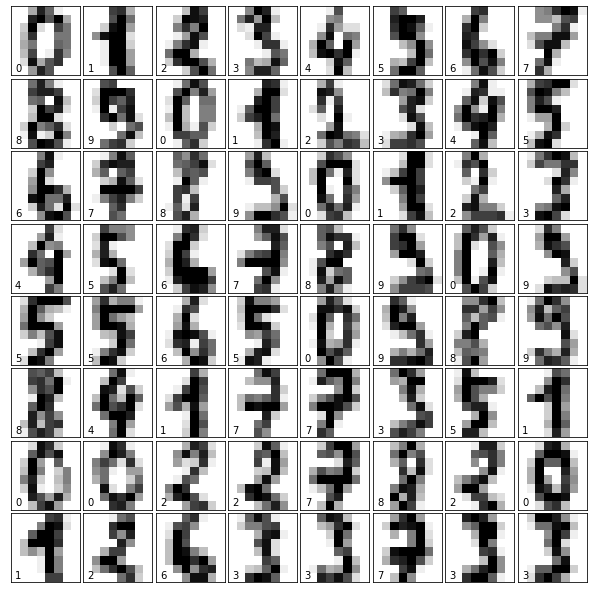

In [22]:
digits = load_digits()

fig = plt.figure(figsize=(8, 8))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [18]:
n_initial = 100
X, y = load_digits(return_X_y=True)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y)

initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
print(X_pool.shape)

(1797, 64)
(1247, 64)


### Initializing the learner

Along with our pool-based sampling strategy, `modAL`’s modular design allows you to vary parameters surrounding the active learning process, **including the core estimator and query strategy.**

Now we initialize the active learner. Feel free to change the underlying `RandomForestClassifier` or the `uncertainty_sampling`!

In [19]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

## We also set how many queries we want to make. The more the better!
n_queries = 20

### The active learning loop

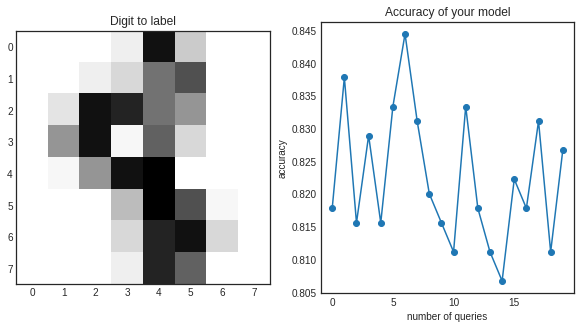

Which digit is this?
4


In [20]:
accuracy_scores = [learner.score(X_test, y_test)]

for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner.query(X_pool)
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Digit to label')
        plt.imshow(query_inst.reshape(8, 8))
        plt.subplot(1, 2, 2)
        plt.title('Accuracy of your model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')
    # Query the rater
    print("Which digit is this?")
    y_new = np.array([int(input())], dtype=int)
    learner.teach(query_inst.reshape(1, -1), y_new)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(X_test, y_test))

By querying hard example to the rater, the performance increase from 83% to 86%!

### Iris example

In this example, we use `scikit-learn`’s `k-nearest neighbors classifier` as our estimator and default to `modAL`’s uncertainty sampling query strategy.

In [23]:
# Set our RNG seed for reproducibility
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [24]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']
print(X_raw.shape)

(150, 4)


In [25]:
# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

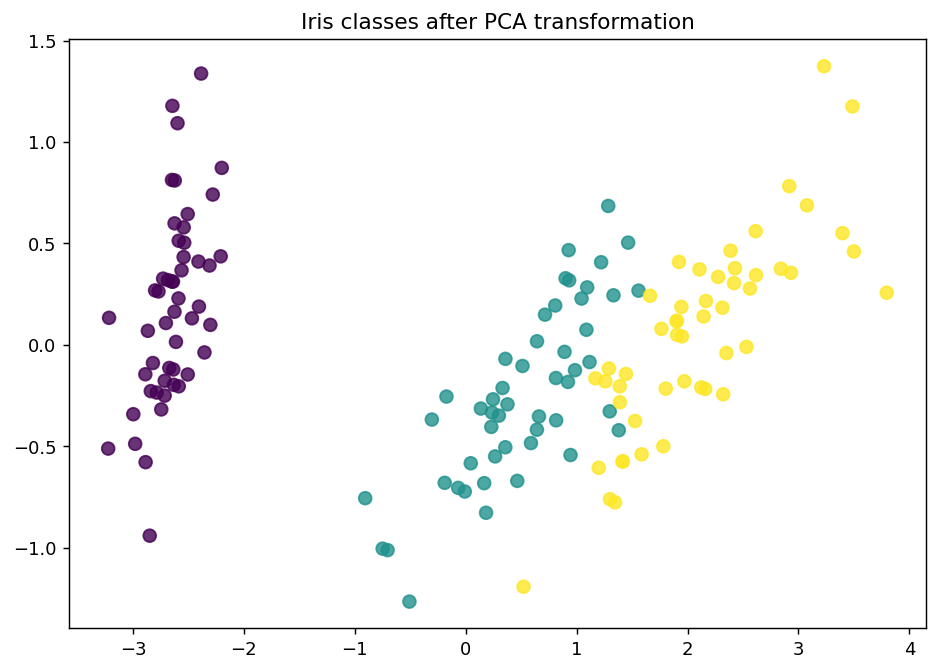

In [26]:
# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

Now we partition our iris dataset into a training set `L` and `U`. We first specify our training set `L` consisting of 3 random examples. The remaining examples go to our “unlabeled” pool `U`.

In [27]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

For the classification, we are going to use a simple `k-nearest neighbors classifier`. In this step, we are also going to initialize the `ActiveLearner`.

In [28]:
# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

Let’s see how our classifier performs on the initial training set!

In [30]:
# Isolate the data we'll need for plotting.
print(y_train)
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

[2 2 1]


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

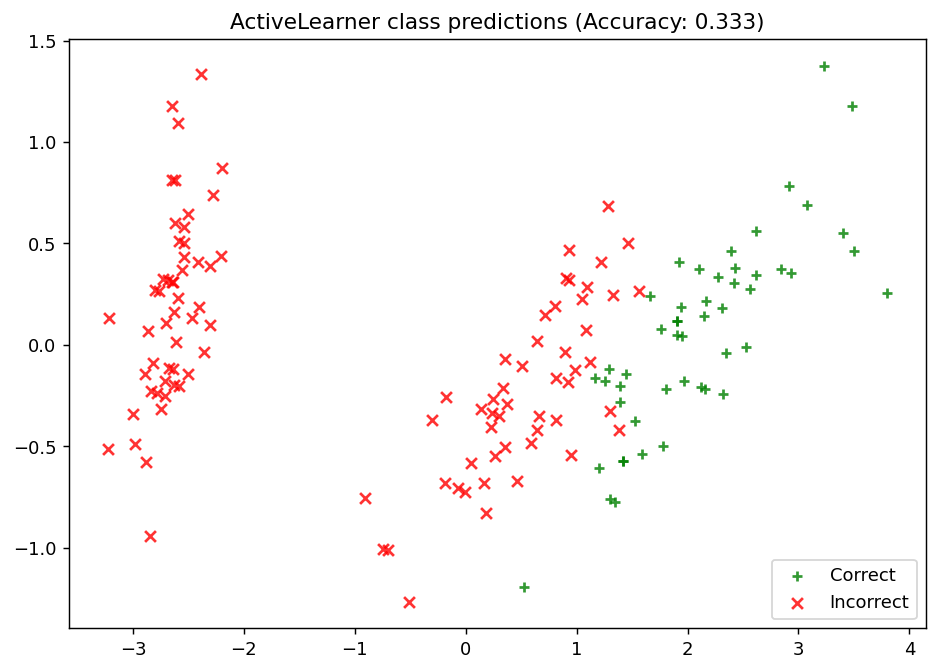

In [31]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

#### Update our model by pool-based sampling our “unlabeled” dataset U


As we can see, our model is unable to properly learn the underlying data distribution. All of its predictions are for the third class label, and as such it is only as competitive as defaulting its predictions to a single class – if only we had more data!

Below, we tune our classifier by allowing it to query 20 instances it hasn’t seen before. Using uncertainty sampling, **our classifier aims to reduce the amount of uncertainty in its predictions using a variety of measures** — see https://modal-python.readthedocs.io/en/latest/index.html for more on specific classification uncertainty measures. With each requested query, we remove that record from our pool `U` and record our model’s accuracy on the raw dataset.

In [32]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  # Here we assume the label comes from the true label!!!
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267


Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot the correct and incorrect predictions on the full dataset.

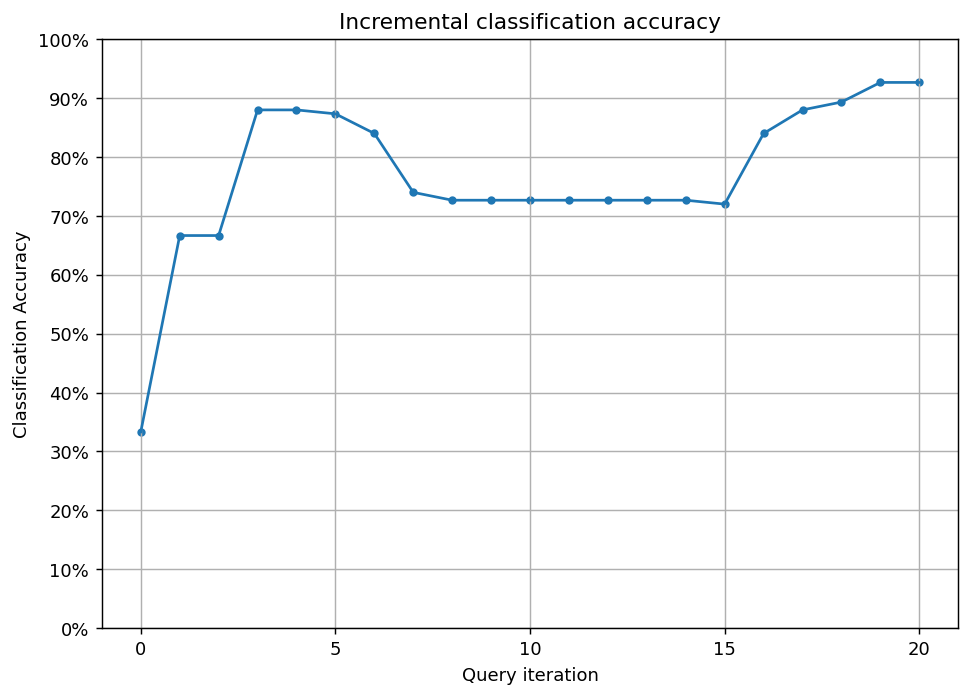

In [33]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

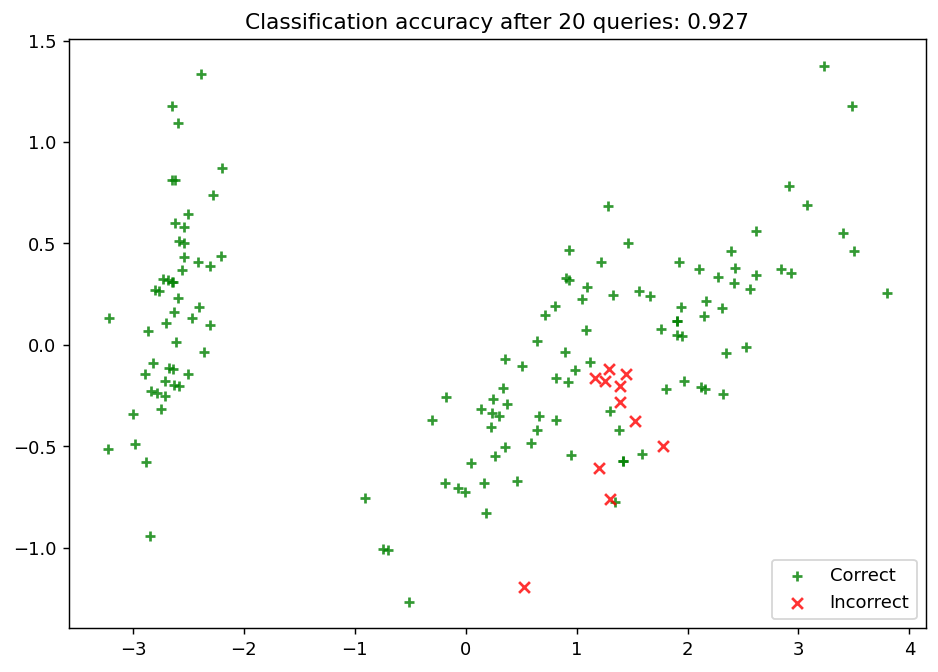

In [34]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

## Weak Supervison using Snorkel

We will walk through the process of using `Snorkel` to build a training set for classifying YouTube comments as spam or not spam. The goal of this tutorial is to illustrate the basic components and concepts of `Snorkel` in a simple way, but also to dive into the actual process of iteratively developing real applications in `Snorkel`.

Our goal is to train a classifier over the comment data that can predict whether a comment is spam or not spam. We have access to a large amount of unlabeled data in the form of YouTube comments with some metadata. In order to train a classifier, we need to label our data, **but doing so by hand for real world applications can often be prohibitively slow and expensive.**

In these cases, we can turn to a weak supervision approach, using **labeling functions (LFs)** in Snorkel: noisy, programmatic rules and heuristics that assign labels to unlabeled training data. 

We’ll dive into the Snorkel API and how we write labeling functions later in this tutorial, but as an example, we can write a LF that labels data points with "http" in the comment text as spam since many spam comments contain links.

We use a [YouTube comments dataset](https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection) that consists of YouTube comments from 5 videos. The task is to classify each comment as being

HAM: comments relevant to the video (even very simple ones), or SPAM: irrelevant (often trying to advertise something) or inappropriate messages

In [36]:
%%file download_data.sh

#!/bin/bash
set -euxo pipefail

FILES=( "Youtube01-Psy.csv" "Youtube02-KatyPerry.csv" "Youtube03-LMFAO.csv" "Youtube04-Eminem.csv" "Youtube05-Shakira.csv" )
DATA_URL="http://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip"
RELOAD=false

# Check if at least any file is missing. If so, reload all data.
for filename in "${FILES[@]}"
do
    if [ ! -e "data/$filename" ]; then
        RELOAD=true
    fi
done

if [ "$RELOAD" = true ]; then
    if [ -d "data/" ]; then rm -Rf "data/"; fi
    mkdir -p data
    curl $DATA_URL > data.zip
    mv data.zip data/
    cd data
    unzip data.zip
    rm data.zip
    rm -rf __MACOSX
    cd ..
fi

Writing download_data.sh


In [35]:
def load_spam_dataset(load_train_labels: bool = False, split_dev_valid: bool = False):
    if os.path.basename(os.getcwd()) == "snorkel-tutorials":
        os.chdir("spam")
    try:
        subprocess.run(["bash", "download_data.sh"], check=True, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as e:
        print(e.stderr.decode())
        raise e
    filenames = sorted(glob.glob("data/Youtube*.csv"))

    dfs = []
    for i, filename in enumerate(filenames, start=1):
        df = pd.read_csv(filename)
        # Lowercase column names
        df.columns = map(str.lower, df.columns)
        # Remove comment_id field
        df = df.drop("comment_id", axis=1)
        # Add field indicating source video
        df["video"] = [i] * len(df)
        # Rename fields
        df = df.rename(columns={"class": "label", "content": "text"})
        # Shuffle order
        df = df.sample(frac=1, random_state=123).reset_index(drop=True)
        dfs.append(df)

    df_train = pd.concat(dfs[:4])
    df_dev = df_train.sample(100, random_state=123)

    if not load_train_labels:
        df_train["label"] = np.ones(len(df_train["label"])) * -1
    df_valid_test = dfs[4]
    df_valid, df_test = train_test_split(
        df_valid_test, test_size=250, random_state=123, stratify=df_valid_test.label
    )

    if split_dev_valid:
        return df_train, df_dev, df_valid, df_test
    else:
        return df_train, df_test

We split our data into two sets:

* **Training Set**: The largest split of the dataset, and the one without any ground truth (“gold”) labels. We will generate labels for these data points with weak supervision.

* **Test Set**: A small, standard held-out blind hand-labeled set for final evaluation of our classifier. This set should only be used for final evaluation, not error analysis.

> Note that in more advanced production settings, we will often further split up the available hand-labeled data into a development split, for getting ideas to write labeling functions, and a validation split for e.g. checking our performance without looking at test set scores, hyperparameter tuning, etc. These splits are omitted for simplicity here.

### Loading Data

We load the YouTube comments dataset and create Pandas DataFrame objects for the train and test sets. Snorkel provides native support for several DataFrame-like data structures, including `Pandas`, `Dask`, and `PySpark`.

Each DataFrame consists of the following fields:

* author: Username of the comment author
* data: Date and time the comment was posted
* text: Raw text content of the comment
* label: Whether the comment is SPAM (1), HAM (0), or UNKNOWN/ABSTAIN (-1)
* video: Video the comment is associated with

We start by loading our data. The `load_spam_dataset()` method downloads the raw CSV files from the internet, divides them into splits, converts them into `DataFrames`, and shuffles them. As mentioned above, the dataset contains comments from 5 of the most popular YouTube videos during a period between 2014 and 2015. **The first four videos’ comments are combined to form the train set. This set has no gold labels. The fifth video is part of the test set.**

In [37]:
df_train, df_test = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_test = df_test.label.values

In [38]:
df_train

,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1
...,...,...,...,...,...
443,Themayerlife,NaN,Check out my mummy chanel!,-1.0,4
444,Fill Reseni,2015-05-27T17:10:53.724000,The rap: cool Rihanna: STTUUPID﻿,-1.0,4
445,Greg Fils Aimé,NaN,I hope everyone is in good spirits I&#39;m a h...,-1.0,4
446,Lil M,NaN,Lil m !!!!! Check hi out!!!!! Does live the wa...,-1.0,4


In [39]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

### Writing Labeling Functions (LFs)

Labeling functions (LFs) help users encode domain knowledge and other supervision sources programmatically.

LFs are heuristics that take as input a data point and either assign a label to it (in this case, HAM or SPAM) or abstain (don’t assign any label). **Labeling functions can be noisy: they don’t have perfect accuracy and don’t have to label every data point. Moreover, different labeling functions can overlap (label the same data point) and even conflict (assign different labels to the same data point).** This is expected, and we demonstrate how we deal with this later.

Because their only requirement is that they map a data point a label (or abstain), they can wrap a wide variety of forms of supervision.

Typical LF development cycles include multiple iterations of ideation, refining, evaluation, and debugging. A typical cycle consists of the following steps:

1. Look at examples to generate ideas for LFs
2. Write an initial version of an LF
3. Spot check its performance by looking at its output on data points in the training set (or development set if available)
4. Refine and debug to improve coverage or accuracy as necessary

Our goal for LF development is to create a high quality set of training labels for our unlabeled dataset, not to label everything or directly create a model for inference using the LFs. The training labels are used to train a separate discriminative model (in this case, one which just uses the comment text) in order to generalize to new, unseen data points. Using this model, we can make predictions for data points that our LFs don’t cover.

a) Pattern-matching LFs (regular expressions)

Labeling functions in `Snorkel` are created with the `@labeling_function` decorator. **The decorator can be applied to any Python function that returns a label for a single data point.**

> See https://realpython.com/primer-on-python-decorators/ for more details about decorators.

Let’s start developing an LF to catch instances of commenters trying to get people to “check out” their channel, video, or website. We’ll start by just looking for the exact string "check out" in the text, and see how that compares to looking for just "check" in the text. For the two versions of our rule, we’ll write a Python function over a single data point that express it, then add the decorator.

One dominant pattern in the comments that look like spam (which we might know from prior domain experience, or from inspection of a few training data points) is the use of the phrase **“check out”** (e.g. “check out my channel”). Let’s start with that.

In [40]:
@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

b) Keyword LFs

For text applications, some of the simplest LFs to write are often just keyword lookups. These will often follow the same execution pattern, so we can create a template and use the resources parameter to pass in LF-specific keywords. Similar to the `labeling_function` decorator, the `LabelingFunction` class wraps a Python function (the `f` parameter), and we can use the resources parameter to pass in keyword arguments (here, our keywords to lookup) to said function.

In [41]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments suspicious."""
keyword_guys = make_keyword_lf(keywords=["guys"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])



"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

c) Heuristic LFs
There may other heuristics or “rules of thumb” that you come up with as you look at the data. So long as you can express it in a function, it’s a viable LF!

In [42]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

In [43]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_guys,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
]

To apply one or more LFs that we’ve written to a collection of data points, we use an `LFApplier`. Because our data points are represented with a `Pandas` `DataFrame` in this tutorial, we use the `PandasLFApplier`. Correspondingly, a single data point `x` that’s passed into our LFs will be a `Pandas` `Series` object.

It’s important to note that these LFs will work for any object with an attribute named text, not just `Pandas` objects. `Snorkel` has several other appliers for different data point collection types which you can browse in the https://snorkel.readthedocs.io/en/master/packages/labeling.html.

The output of the `apply(...)` method is a label matrix, a fundamental concept in `Snorkel`. It’s a `NumPy` array `L` with one column for each LF and one row for each data point, where `L[i, j]` is the label that the jth labeling function output for the ith data point. We’ll create a label matrix for the train set.

In [44]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 250/250 [00:00<00:00, 12829.13it/s]


We can easily calculate the coverage of these LFs (i.e., the percentage of the dataset that they label) as follows:

In [45]:
coverage = (L_train != ABSTAIN).mean(axis=0)
coverage

array([0.19861286, 0.12736444, 0.11916772, 0.05674653, 0.11223203,
       0.14186633, 0.23392182, 0.22572509])

In [46]:
L_train

array([[-1, -1,  1, ..., -1, -1, -1],
       [-1,  1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 1,  1, -1, ..., -1,  1, -1],
       [-1,  1, -1, ..., -1,  1, -1],
       [ 1, -1, -1, ..., -1,  1, -1]])

Lots of statistics about labeling functions - like coverage - are useful when building any `Snorkel` application. So Snorkel provides tooling for common LF analyses using the `LFAnalysis` utility. 

Checkout the statistics here https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFAnalysis.html

In [47]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_my,0,[1],0.198613,0.172131,0.044136
keyword_subscribe,1,[1],0.127364,0.092055,0.026482
keyword_http,2,[1],0.119168,0.083859,0.051702
keyword_guys,3,[1],0.056747,0.055485,0.005044
keyword_please,4,[1],0.112232,0.104666,0.023960
keyword_song,5,[0],0.141866,0.071879,0.045397
regex_check_out,6,[1],0.233922,0.116015,0.022068
short_comment,7,[0],0.225725,0.100883,0.074401


Our goal is now to convert the labels from our LFs into a single noise-aware probabilistic (or confidence-weighted) label per data point. A simple baseline for doing this is to take the majority vote on a per-data point basis: **if more LFs voted SPAM than HAM, label it SPAM (and vice versa)**. We can test this with the `MajorityLabelVoter` baseline model.

In [48]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

The LFs may have varying properties and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. 

To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs. **This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task.**

Note that no gold labels are used during the training process. The only information we need is the label matrix, which contains the output of the LFs on our training set. The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input. We also specify the **cardinality, or number of classes.**

In [49]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

100%|██████████| 500/500 [00:00<00:00, 1331.28epoch/s]


In [50]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   86.4%
Label Model Accuracy:     84.8%


The majority vote model or more sophisticated `LabelModel` could in principle be used directly as a classifier if the outputs of our labeling functions were made available at test time. However, these models (i.e. these re-weighted combinations of our labeling function’s votes) will abstain on the data points that our labeling functions don’t cover.

We will instead use the outputs of the `LabelModel` as training labels to train a discriminative classifier which can generalize beyond the labeling function outputs to see if we can improve performance further. This classifier will also only need the text of the comment to make predictions, making it much more suitable for inference over unseen comments.

Let's briefly confirm that the labels the `LabelModel` produces are indeed probabilistic in nature. The following histogram shows the confidences we have that each data point has the label SPAM. The points we are least certain about will have labels close to 0.5.

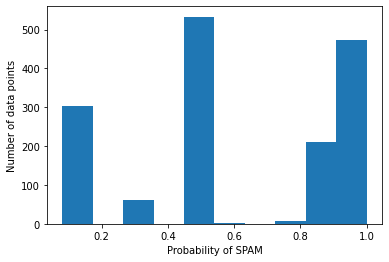

In [51]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

As we saw earlier, some of the data points in our train set received no labels from any of our LFs. These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a built-in utility.

In [52]:
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

### Training a Classifier

In this final section of the tutorial, we’ll use the probabilistic training labels we generated in the last section to train a classifier for our task. The output of the `Snorkel` `LabelModel` is just a set of labels which can be used with most popular libraries for performing supervised learning. Note that typically, `Snorkel` is used (and really shines!) with much more complex, training data-hungry models, but we will use Logistic Regression here for simplicity of exposition.

For simplicity and speed, we use a simple “bag of n-grams” feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the comment text.

In [53]:
vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

If we want to use a library or model that doesn’t accept probabilistic labels (such as `Scikit-Learn`), we can instead replace each label distribution with the label of the class that has the maximum probability. This can easily be done using the `probs_to_preds` helper method. **We do note, however, that this transformation is lossy**, as we no longer have values for our confidence in each label.

In [54]:
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

We then use these labels to train a classifier as usual.

In [55]:
sklearn_model = LogisticRegression(C=1e2, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=100.0, solver='liblinear')

In [56]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 91.2%


We observe an additional boost in accuracy over the `LabelModel` by multiple points! This is in part because the discriminative model generalizes beyond the labeling function’s labels and makes good predictions on all data points, not just the ones covered by labeling functions. By using the label model to transfer the domain knowledge encoded in our LFs to the discriminative model, we were able to generalize beyond the noisy labeling heuristics.

## Data augmentation using Albumentations

`Scikit-image` reads an image in RGB format which is consistent with `Albumentations`.

In [57]:
!wget https://raw.githubusercontent.com/albumentations-team/albumentations_examples/master/notebooks/images/image_3.jpg

--2023-02-19 04:39:13--  https://raw.githubusercontent.com/albumentations-team/albumentations_examples/master/notebooks/images/image_3.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58095 (57K) [image/jpeg]
Saving to: ‘image_3.jpg’

image_3.jpg         100%[===================>]  56.73K  --.-KB/s    in 0.002s  

2023-02-19 04:39:13 (31.1 MB/s) - ‘image_3.jpg’ saved [58095/58095]



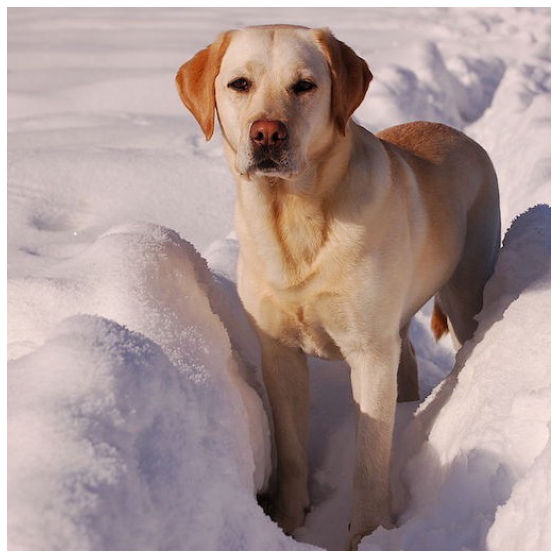

In [58]:
image = io.imread('image_3.jpg')
visualize(image)

We fix the random seed for visualization purposes, so the augmentation will always produce the same result. In a real computer vision pipeline, **you shouldn't fix the random seed** before applying a transform to the image because, in that case, the pipeline will always output the same image. The purpose of image augmentation is to use different transformations each time

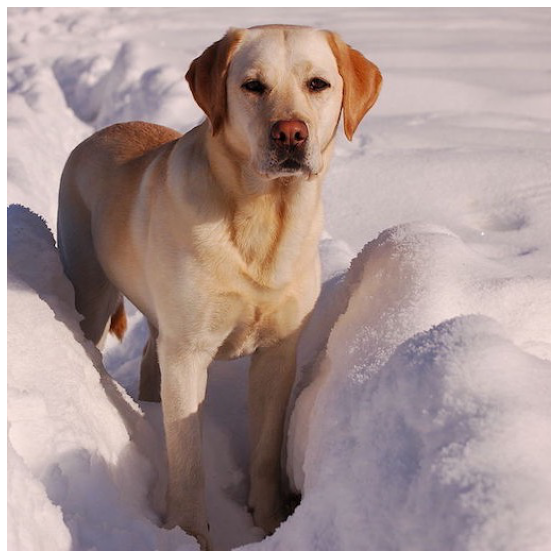

In [59]:
# Define a single augmentation, pass the image to it and receive the augmented image
transform = A.HorizontalFlip(p=0.5)
random.seed(7)
augmented_image = transform(image=image)['image']
visualize(augmented_image)

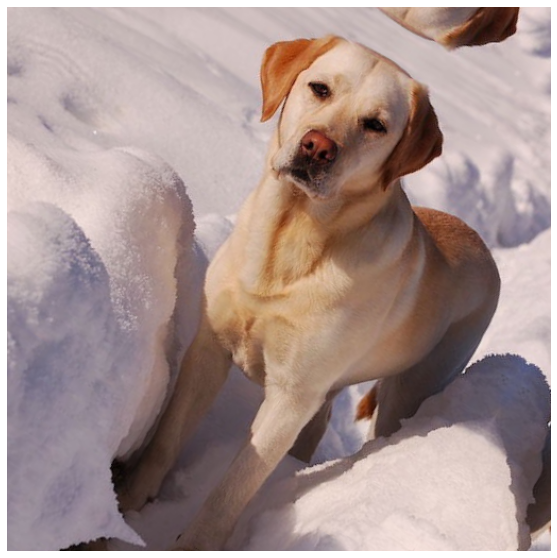

In [60]:
transform = A.ShiftScaleRotate(p=0.5)
random.seed(7) 
augmented_image = transform(image=image)['image']
visualize(augmented_image)

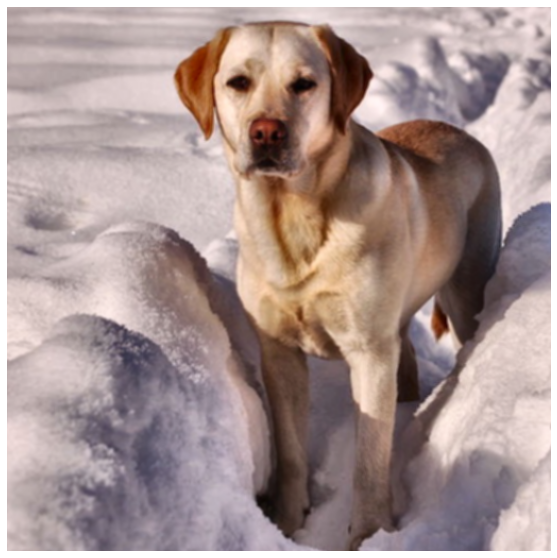

In [61]:
#Define an augmentation pipeline using Compose, pass the image to it and receive the augmented imag
transform = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])
random.seed(42) 
augmented_image = transform(image=image)['image']
visualize(augmented_image)

In [62]:
io.imsave('augmented_image.jpg', augmented_image)

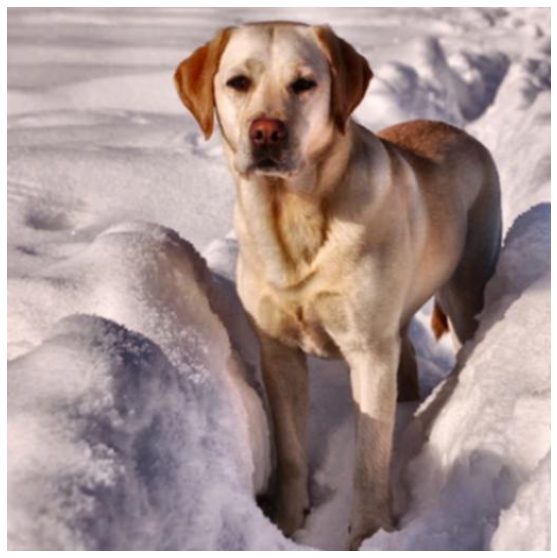

In [63]:
image = io.imread('augmented_image.jpg')
visualize(image)

For more information, please refer to https://albumentations.ai/docs/#examples.

## Reference

_This notebook contains the sample from https://github.com/dennisbakhuis/pigeonXT/blob/master/pigeonXT_Examples.ipynb, https://docs.cleanlab.ai/stable/tutorials/multiannotator.html, https://modal-python.readthedocs.io/en/latest/content/examples/interactive_labeling.html_, https://modal-python.readthedocs.io/en/latest/content/examples/pool-based_sampling.html, https://www.snorkel.org/use-cases/01-spam-tutorial and https://albumentations.ai/docs/#examples.